# HW1 : Regression, Cross-Validation, and  Regularization

In [19]:
import os
import numpy as np
import pandas as pd
 
import sklearn.preprocessing
import sklearn.pipeline
import sklearn.linear_model

In [20]:
from matplotlib import pyplot as plt

import seaborn as sns
sns.set('notebook', font_scale=1.25, style='whitegrid')

### Configuration

In [21]:
SEED = 12345 

DATA_DIR = './data_auto/'

### Methods for loading dataset

In [22]:
def load_2d_arr_from_csv(fname, include_header=False):
    x = np.loadtxt(os.path.join(DATA_DIR, fname), delimiter=',', skiprows=1)
    assert x.ndim == 2
    if include_header:
        header_cols = np.loadtxt(os.path.join(DATA_DIR, fname), delimiter=',', dtype=str)[0].tolist()
        return x, header_cols
    else:
        return x
    
def load_1d_arr_from_csv(fname):
    x = np.loadtxt(os.path.join(DATA_DIR, fname), delimiter=',', skiprows=1)
    if x.ndim == 1:
        return x
    else:
        raise ValueError("Not 1d")

# Load the dataset

Predefined 'x' and 'y' arrays for train/valid/test

In [23]:
x_tr_MF, xcolnames_F = load_2d_arr_from_csv('x_train.csv', include_header=True)
x_va_NF = load_2d_arr_from_csv('x_valid.csv')
x_te_PF = load_2d_arr_from_csv('x_test.csv')

In [24]:
print(xcolnames_F)

['horsepower', 'weight', 'cylinders', 'displacement']


In [25]:
print(x_tr_MF[:5])

[[ 115. 2595.    6.  173.]
 [ 180. 4380.    8.  350.]
 [ 150. 4457.    8.  318.]
 [ 105. 3897.    6.  250.]
 [ 193. 4732.    8.  304.]]


In [26]:
y_tr_M = load_1d_arr_from_csv('y_train.csv')
y_va_N = load_1d_arr_from_csv('y_valid.csv')
y_te_P = load_1d_arr_from_csv('y_test.csv')

In [27]:
print(y_tr_M[:5,np.newaxis])

[[28.8]
 [16.5]
 [14. ]
 [16. ]
 [ 9. ]]


In [28]:
y_tr_M.max()

46.6

In [29]:
Y_MAX = 60.0

## Load completed code

In [30]:
from performance_metrics import calc_root_mean_squared_error
from cross_validation import train_models_and_calc_scores_for_n_fold_cv

## Define useful plotting functions

In [31]:
def plot_train_and_valid_error_vs_hyper(
        hyper_list, err_tr_list=None, err_va_list=None,
        ymax=40,
        leg_loc='upper right',
        xlabel='polynomial degree',
        ylabel='RMSE'):
    if err_va_list is not None:
        plt.plot(hyper_list, err_va_list, 'rs-', label='valid');
    if err_tr_list is not None:
        plt.plot(hyper_list, err_tr_list, 'bd:', label='train');
    plt.ylim([0, ymax]);
    plt.legend(loc=leg_loc);
    plt.xlabel(xlabel);
    plt.ylabel(ylabel);

## Method to sanitize predictions

We are predicting MPG, which should 
* (1) always be positive, and
* (2) will probably never exceed 120% of the largest value we see in train data

In [32]:
def sanitize(yhat_N):
    yhat_N = np.maximum(yhat_N, 0)
    yhat_N = np.minimum(yhat_N, Y_MAX)
    return yhat_N

In [33]:
bad_yhat_N = np.asarray([-10, -1, 0, 1, 5, 10, 50, 55, 60, 65])

In [34]:
bad_yhat_N

array([-10,  -1,   0,   1,   5,  10,  50,  55,  60,  65])

In [35]:
sanitize(bad_yhat_N)

array([ 0.,  0.,  0.,  1.,  5., 10., 50., 55., 60., 60.])

## Methods for building pipelines

In [36]:
def make_poly_linear_regr_pipeline(degree=1):
    pipeline = sklearn.pipeline.Pipeline(
        steps=[
         ('rescaler', sklearn.preprocessing.MinMaxScaler()),
         ('poly_transformer', sklearn.preprocessing.PolynomialFeatures(degree=degree, include_bias=False)),
         ('linear_regr', sklearn.linear_model.LinearRegression()),
        ])
    
    # Return the constructed pipeline
    # We can treat it as if it has a 'regression' API
    # e.g. a fit and a predict method
    return pipeline

In [37]:
def make_poly_ridge_regr_pipeline(degree=1, alpha=1.0):
    pipeline = sklearn.pipeline.Pipeline(
        steps=[
         ('rescaler', sklearn.preprocessing.MinMaxScaler()),
         ('poly_transformer', sklearn.preprocessing.PolynomialFeatures(degree=degree, include_bias=False)),
         ('linear_regr', sklearn.linear_model.Ridge(alpha=alpha)),
        ])

    # Return the constructed pipeline
    # We can treat it as if it has a 'regression' API
    # e.g. a fit and a predict method
    return pipeline

## Method to inspect learned weights

In [38]:
def pretty_print_learned_weights(pipeline, xcolnames_F):
    ''' Print the learned parameters of given pipeline
    '''
    my_lin_regr = pipeline.named_steps['linear_regr']

    feat_names = pipeline.named_steps['poly_transformer'].get_feature_names_out()
    coef_values = my_lin_regr.coef_

    for feat, coef in zip(feat_names, coef_values):
        print("% 7.2f : %s" % (coef, feat))
    
    print("where ")
    for ff, colname in enumerate(xcolnames_F):
        print("x%d = %s" % (ff, colname))

# Problem 1: Polynomial Degree Selection on Fixed Validation Set

**Implementation Step 1A:**

Fit a linear regression model to a polynomial feature transformation of the provided training set at each of these possible degrees: [1, 2, 3, 4, 5, 6, 7]. For each hyperparameter setting, record the training set error and the validation set error.

In [77]:
degree_list = [1, 2, 3, 4, 5, 6, 7]
fv_err_tr_list = []
fv_err_va_list = []

fv_pipeline_list = []
for degree in degree_list:

    # TODO create a pipeline using features with current degree value
    # TODO train this pipeline on provided training data

    pipeline1 = make_poly_linear_regr_pipeline(degree)
    pipeline1.fit(x_tr_MF, y_tr_M)
    
    
    # Compute training error
    # TODO fixme, be sure to sanitize predictions
    # TODO fixme, be sure to sanitize predictions

    yhat_tr_M = sanitize(pipeline1.predict(x_tr_MF)) 
    yhat_va_N = sanitize(pipeline1.predict(x_va_NF))

    err_tr = calc_root_mean_squared_error(y_tr_M, yhat_tr_M) # TODO fixme
    err_va = calc_root_mean_squared_error(y_va_N, yhat_va_N) # TODO fixme

    fv_err_tr_list.append(err_tr)
    fv_err_va_list.append(err_va)
    
    # TODO store current pipeline for future use
    fv_pipeline_list.append(pipeline1)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Figure 1: Error vs degree

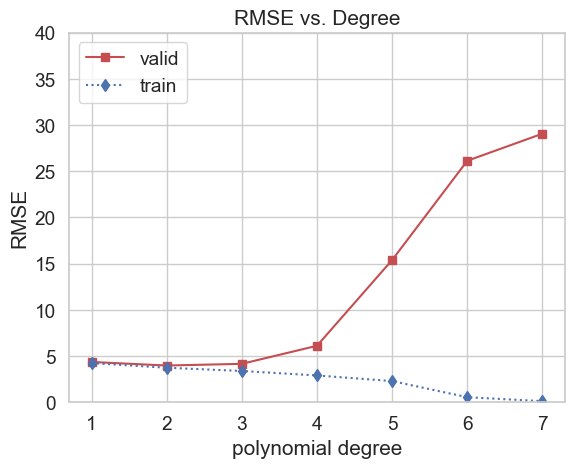

In [86]:
plot_train_and_valid_error_vs_hyper(
    degree_list, fv_err_tr_list, fv_err_va_list, leg_loc='upper left');
plt.title('RMSE vs. Degree');

### Implementation 1B: Score on the test set using the chosen model

Select the model hyperparameters that *minimize* your fixed validation set error. Using your already-trained LinearRegression model with these best hyperparameters, compute error on the *test* set. Save this test set error value for later.

In [109]:
min_err_va1 = min(fv_err_va_list)
min_index1 = fv_err_va_list.index(min_err_va1)

min_degree1 = degree_list[min_index1]
print(min_degree1)
min_pipeline1 = fv_pipeline_list[min_index1]

yhat_te_P1 = min_pipeline1.predict(x_te_PF)
test_err1 = calc_root_mean_squared_error(y_te_P, yhat_te_P1)


print("Selected Parameters:")
print("TODO")
print("Fixed validation set estimate of heldout error:")
print("TODO")
print("Error on the test-set:")
print("TODO")

2
Selected Parameters:
TODO
Fixed validation set estimate of heldout error:
TODO
Error on the test-set:
TODO


In [108]:
# TODO store score on test set for later
test_RMSE1 = test_err1
print(test_RMSE1)

3.9915025464567564


### Short Answer 1a in Report

Investigate why preprocessing is necessary

In [25]:
# WRITE THIS IN YOUR REPORT, NOT IN THIS NOTEBOOK

### Short Answer 1b in Report

Consider the model with degree 1. 
Following the starter code, print out the values of **all** the learned weight parameters (aka coefficients).

In [44]:
# TODO call pretty_print_learned_weights on your pipeline with degree=1 from above
# Hint: The names of the original F=4 features are already in your workspace


pretty_print_learned_weights(fv_pipeline_list[0], xcolnames_F)

print(xcolnames_F)

 -10.43 : x0
 -18.23 : x1
  -1.15 : x2
   0.58 : x3
where 
x0 = horsepower
x1 = weight
x2 = cylinders
x3 = displacement
['horsepower', 'weight', 'cylinders', 'displacement']


### Short Answer 1c in Report

Consider the models with degree 3 or 4. 
Inspect the learned weight parameters, including the number of parameters and their relative magnitudes.

What do you notice about these values compared to the values with degree 1 or 2?
How might what you notice be connected to the trends in training and validation set performance you observe in Figure 1?

In [61]:
# TODO
pretty_print_learned_weights(fv_pipeline_list[3], xcolnames_F)

 617.45 : x0
-191.08 : x1
 1774.24 : x2
-1343.56 : x3
 159.25 : x0^2
-323.66 : x0 x1
-5179.64 : x0 x2
 198.45 : x0 x3
  61.37 : x1^2
 2573.25 : x1 x2
-1596.95 : x1 x3
-5943.40 : x2^2
 7359.52 : x2 x3
 2883.15 : x3^2
-630.58 : x0^3
 1377.51 : x0^2 x1
-1600.47 : x0^2 x2
 1529.25 : x0^2 x3
-105.12 : x0 x1^2
-7880.76 : x0 x1 x2
 12085.95 : x0 x1 x3
 13051.50 : x0 x2^2
 5626.91 : x0 x2 x3
-14222.70 : x0 x3^2
 611.22 : x1^3
-1478.94 : x1^2 x2
-359.76 : x1^2 x3
-7343.55 : x1 x2^2
 17674.97 : x1 x2 x3
-13648.53 : x1 x3^2
 4525.05 : x2^3
  47.94 : x2^2 x3
-34068.88 : x2 x3^2
 20804.11 : x3^3
-345.94 : x0^4
 1047.47 : x0^3 x1
 133.89 : x0^3 x2
 702.32 : x0^3 x3
 1031.68 : x0^2 x1^2
 3678.25 : x0^2 x1 x2
-11633.91 : x0^2 x1 x3
-1147.94 : x0^2 x2^2
 1506.00 : x0^2 x2 x3
 3042.21 : x0^2 x3^2
-5637.55 : x0 x1^3
 3990.55 : x0 x1^2 x2
 7624.03 : x0 x1^2 x3
 12467.48 : x0 x1 x2^2
-36650.46 : x0 x1 x2 x3
 19120.42 : x0 x1 x3^2
-6959.36 : x0 x2^3
-12414.29 : x0 x2^2 x3
 31670.59 : x0 x2 x3^2
-15448.88 : 

# Problem 2: Alpha Selection on Fixed Val Set

In [54]:
my_degree = 4
alpha_list = np.asarray([1.e-10, 1.e-08, 1.e-06, 1.e-04, 1.e-02, 1.e+00, 1.e+02, 1.e+04, 1.e+06])
print(alpha_list)

[1.e-10 1.e-08 1.e-06 1.e-04 1.e-02 1.e+00 1.e+02 1.e+04 1.e+06]


In [88]:
fv2_err_tr_list = []
fv2_err_va_list = []
fv2_pipeline_list = []

for alpha in alpha_list:

    # TODO create a pipeline using features with current degree value
    # TODO train this pipeline on provided training data
    
    pipeline2 = make_poly_ridge_regr_pipeline(my_degree, alpha)
    pipeline2.fit(x_tr_MF, y_tr_M)
    
    
    # Compute training error
    # TODO fixme, be sure to sanitize predictions
    # TODO fixme, be sure to sanitize predictions

    yhat_tr_M = sanitize(pipeline2.predict(x_tr_MF)) 
    yhat_va_N = sanitize(pipeline2.predict(x_va_NF))

    assert np.all(yhat_va_N >= 0.0)
    assert np.all(yhat_va_N <= Y_MAX)

    err_tr = calc_root_mean_squared_error(y_tr_M, yhat_tr_M)
    err_va = calc_root_mean_squared_error(y_va_N, yhat_va_N)

    fv2_err_tr_list.append(err_tr)
    fv2_err_va_list.append(err_va)

    # TODO store current pipeline for future use
    fv2_pipeline_list.append(pipeline2)
    

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Figure 2 in report

Make a line plot of mean-squared error on y-axis vs. alpha on x-axis.

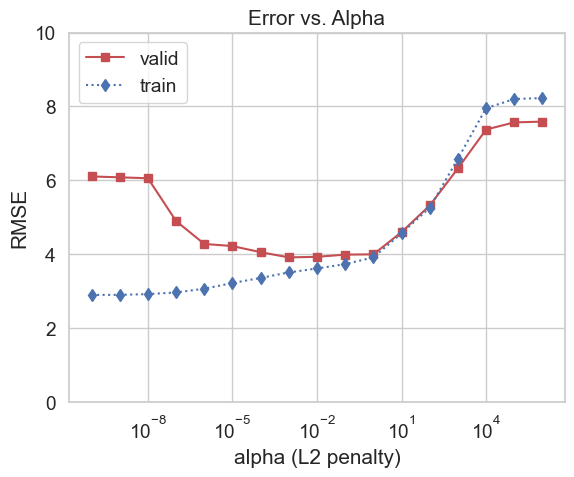

In [89]:
plot_train_and_valid_error_vs_hyper(
    alpha_list, fv2_err_tr_list, fv2_err_va_list,
    xlabel='alpha (L2 penalty)', leg_loc='upper left');
plt.gca().set_ylim([0, 10]);
plt.gca().set_xscale('log');
plt.title('Error vs. Alpha');

### Implementation Step 2B

Select the model hyperparameters that *minimize* your fixed validation set error. Using your already-trained model with these best hyperparameters, compute error on the *test* set. 


In [111]:
min_err_va2 = min(fv2_err_va_list)
min_index2 = fv2_err_va_list.index(min_err_va2)

min_alpha2 = alpha_list[min_index2]
print(min_alpha2)
min_pipeline2 = fv2_pipeline_list[min_index2]

yhat_te_P2 = min_pipeline2.predict(x_te_PF)
test_err2 = calc_root_mean_squared_error(y_te_P, yhat_te_P2)

print("Selected Parameters:")
print("TODO")
print("Fixed validation set estimate of heldout error:")
print("TODO")
print("Error on the test-set:")
print("TODO")

0.001
Selected Parameters:
TODO
Fixed validation set estimate of heldout error:
TODO
Error on the test-set:
TODO


In [91]:
# TODO Save this test set error value for later.

test_RMSE2 = test_err2
print(test_RMSE2)

3.8931953656019496


### Short Answer 2a in Report

Inspect the learned weight parameters of your chosen degree-4 model.
What do you notice about the relative magnitudes compared to 1c above?

In [94]:
# TODO
pretty_print_learned_weights(min_pipeline2, xcolnames_F)

 -36.60 : x0
  18.53 : x1
  10.40 : x2
 -24.68 : x3
 -38.19 : x0^2
 -56.65 : x0 x1
  26.08 : x0 x2
  70.53 : x0 x3
 -52.05 : x1^2
  10.30 : x1 x2
  -8.06 : x1 x3
  -4.93 : x2^2
 -98.70 : x2 x3
  62.87 : x3^2
  36.80 : x0^3
  24.02 : x0^2 x1
   9.97 : x0^2 x2
  53.86 : x0^2 x3
  52.10 : x0 x1^2
  12.10 : x0 x1 x2
  62.16 : x0 x1 x3
  29.58 : x0 x2^2
 -28.89 : x0 x2 x3
 -17.00 : x0 x3^2
   6.10 : x1^3
  -0.89 : x1^2 x2
 -15.05 : x1^2 x3
  19.64 : x1 x2^2
 -15.40 : x1 x2 x3
   3.28 : x1 x3^2
  -0.23 : x2^3
 -19.05 : x2^2 x3
   7.43 : x2 x3^2
  41.91 : x3^3
  -3.41 : x0^4
 -39.95 : x0^3 x1
 -15.27 : x0^3 x2
  40.06 : x0^3 x3
 -34.04 : x0^2 x1^2
 -28.00 : x0^2 x1 x2
  21.33 : x0^2 x1 x3
  -8.66 : x0^2 x2^2
  -5.58 : x0^2 x2 x3
   5.62 : x0^2 x3^2
   3.94 : x0 x1^3
   5.86 : x0 x1^2 x2
  29.35 : x0 x1^2 x3
  -0.76 : x0 x1 x2^2
  10.23 : x0 x1 x2 x3
   8.21 : x0 x1 x3^2
 -23.62 : x0 x2^3
 -50.17 : x0 x2^2 x3
 -60.34 : x0 x2 x3^2
 -59.26 : x0 x3^3
   4.83 : x1^4
   7.92 : x1^3 x2
 -10.69 : x1^

# Data preprocessing for Problem 3

For this problem, you'll again use the provided training set and validation sets. However, you'll *merge* these into a large "development" set that contains 292 examples total.

In [103]:
x_trva_LF = np.vstack([x_tr_MF, x_va_NF])
y_trva_L = np.hstack([y_tr_M, y_va_N])

print(x_trva_LF.shape)

(292, 4)


# Problem 3: Cross Validation for Polynomial Feature Regression

### Implementation step 3A

For each possible `alpha` value as well as each possible polynomial degree, train and evaluate a `Ridge` regression model across the entire train+validation set using 10-fold cross validation. Use the CV methods you implemented in `cross_validation.py`. For each possible hyperparameter (alpha value and degree value), your 10-fold CV procedure will give you an estimate of the training error and heldout validation error (averaged across all folds). 


In [104]:
K = 10 # num folds of CV
degree_list = [1, 2, 3, 4, 5, 6, 7]
alpha_list = np.logspace(-10, 6, 17)

ridge_param_list = []
for alpha in alpha_list:
    for degree in degree_list:
        ridge_param_list.append(dict(degree=degree, alpha=alpha))
        
cv_train_err_list = []
cv_valid_err_list = []
for param in ridge_param_list:
    # TODO make pipeline
    pipeline = make_poly_ridge_regr_pipeline(param['degree'], param['alpha'])
    
    # TODO call your function to train a separate model for each fold and return train and valid errors
    # Don't forget to pass random_state = SEED (where SEED is defined above) so its reproducible
    tr_error_K, valid_error_K = train_models_and_calc_scores_for_n_fold_cv(pipeline, x_tr_MF, y_tr_M, 10, SEED)

    err_tr = np.mean(tr_error_K)
    err_va = np.mean(valid_error_K)
    
    cv_train_err_list.append(err_tr)
    cv_valid_err_list.append(err_va)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Implementation step 3B

Select the model hyperparameters that *minimize* your estimated cross-validation error. Using these best hyperparameters, retrain the model using the full development set (concatenating the predefined training and validation sets). Then compute that (retrained) model's error on the test set.

Save this test set error value for later.

In [112]:
# TODO
min_err_va = np.min(cv_valid_err_list)
index = np.argmin(cv_valid_err_list)
min_params = ridge_param_list[index]

print(min_params['degree'])
print(min_params['alpha'])

best_pipeline = make_poly_ridge_regr_pipeline(min_params['degree'], min_params['alpha'])

best_pipeline.fit(x_trva_LF, y_trva_L)

yhat_te_P3 = best_pipeline.predict(x_te_PF)

test_err3 = calc_root_mean_squared_error(y_te_P, yhat_te_P3)


2
0.01
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [66]:
print("Selected Parameters:")
print("TODO")
print("10-fold CV estimate of heldout error:")
print("TODO")
print("Error on the test-set:")
print("TODO")

Selected Parameters:
TODO
10-fold CV estimate of heldout error:
TODO
Error on the test-set:
TODO


## Table 3 : Comparing pipelines on test set

In [116]:
# TODO make a table in your report using the saved values from 1B, 2B and 3B above
test_RMSE3 = test_err3
print(test_RMSE3)

y_baseline = np.mean(y_tr_M)
y_pred = np.full_like(y_te_P, fill_value=y_baseline) # looked this up because was confused about baseline
test_RMSE4 = calc_root_mean_squared_error(y_te_P, y_pred)
print(test_RMSE4)

3.864037370229355
7.104481090304907


This is the 2024S version of this assignment. Please do not remove or make changes to this block. Otherwise, you submission will be viewed as files copied from other resources.